# Análisis de tendencias y anomalias en Twittter.

## Éste notebook es parte del material para el taller de  **análisis de narrativas emergentes, discurso de odio y desinformación en red** desarollado por **Heurística** dentro del projecto DataPolitik.

Permite analizar muestras de recuentos de tweets para detectar puntos de cambio y valores atipicos.

El análisis de la **evolución temporal de recuentos de tweets** (incluyendo retweets) que usan una palabra dada o un hashtag, así cómo un conjunto de palabras clave, nos permite extraer información valiosa sobre la dínamica de la **atención pública**, la emergencia de **nuevas narrativas**, así como dínamicas de **desinformacion**. 

En general, cuando los datos se representan como una sucesión de medidas en determinados momentos ordenados cronologicamente, como es nuestro caso, se habla de *serie temporal*. El intervalo de tiempo entre medidas sucesivas se suele indicar como la granularidad de la *serie temporal*. Varios metodos de análisis existen para extraer información de una serie temporal, en este caso nos fijamos en la detección de puntos de cambio y de valores atipicos.

La detección de **puntos de cambio** nos permitirá identificar si el uso de un dado termino o conjunto de terminos cambia significativamente y, de ser así, cuándo, mientras que la deteccion de **valores atipicos** consiste en identificar las observaciones que se desvían significativamente de la mayoría de los datos y no se ajustan a una noción de comportamiento normal.




## Cómo obtener los datos

El tipo de análisis que vamos a desarrollar en este notebook será útil para los casos en que queremos:

- análizar los efectos a medio y largo plazo de una campaña
- detectar los eventos que han tenido un impacto en la evolución de la atención pública alrededor de un cierto tema
- detectar posibles comportamientos sospechosos en la evolución temporal de la atención recibida por un cierto tema
- monitorear la emergencia o el declive de narrativas

En cada uno de estos casos empezamos con una pregunta más o menos abstracta, el siguiente paso es entender cómo traducir ésta pregunta a una consulta de búsqueda en la API de Twitter.

Se pueden dar dos casos:

 - el tema que queremos estudiar está identificado con un hashtag
 - el tema que queremos estudiar es más amplio y/o difuso.
 
En el primer caso nuestra consulta será simplemente el hashtag en cuestión. 
En el segundo, tendremos que encontrar un conjunto de palabras claves (y de combinaciones entre ellas) que nos permitan capturar una parte representativa de los tweets y retweets sobre el tema. 

Existen varias herramientas para ejecutar consultas a la API de Twitter, en éste caso asumimos que los hemos obtenidos usando el comando [counts](https://twarc-project.readthedocs.io/en/latest/twarc2_en_us/#counts) de [twarc2](https://twarc-project.readthedocs.io/en/latest/twarc2_en_us/) y guardados en formato csv.

No es objetivo de este tutorial describir cómo diseñar una consulta, pero los elementos minimos a tener en cuenta son los siguentes:

- momento de inicio
- momento de fin
- granularidad

Los momentos de inicio y de fin nos darán la ventana temporal en la que ejucatermos nuestro análisis. Esta, estará determinada por el periodo de tiempo que nos interesa y por las limitaciones de acceso a la API de twitter.

La granularidad, cómo se decía arriba, es el intervalo entre una medición y la otra. Por ejemplo, podría ser de una hora, así tendremos el número de tweets y retweets que coinciden con nuestra consulta hora por hora entre el momento de inicio y de fin. Si recogemos los datos con una granularidad diaría, obtendrémos los recuentos día por día, etc.

A cada escala de temporalidad podremos análizar cuestiones distintas de nuestra serie temporal.

Sin embargo, en ausencia de otras limitaciones, es aconcejable descargar los datos con una granularidad minima, ya que luego, como veremos, podremos siempre augmentar esta en fase de análisis, pero no disminuirla.


## Puntos de cambio y tendencias

La detección de **puntos de cambio** nos permite identificar tendencias en los datos. Esto es, identifican momentos en los que las caracteristicas de la serie temporal - concretamente sus propiedades estadisticas - cambian, por ejemplo pasando de una fase más o menos constante a una fase de crecimiento (o viceversa), de una fase de crecimiento a una de decrecimiento (o viceversa), o entre dos fases más o menos constantes pero con valores promedios distintos. 

Por ejemplo, si estamos analizando una campaña, podemos ver si esta ha logrado cambiar la tendendia de la atención entorno al tema tratado. O, si estamos análizando una narrativa, podemos detectar si la atención en esta está ganando momento o pirdiendolo, y relacionar ésto a eventos concretos occurridos. Finalmente, 

## Valores atípicos y eventos

La detección de **valores atípicos** nos permite identificar momentos de excepciónal atención en un tema, o, de lo contrario, momentos de repentina caida de interes.

A diferencias de los puntos de cambios, aquí solo estamos analizando efectos instantaneos que pueden o no haber tenido impacto a medio y largo plazo. 

Por ejemplo, 

## Caveats

Aunque intentamos dar una idea de los detalles tecnicos y matématicos del análisis, este tutorial no tienes estos aspectos cómo centrales.



# Configuración del notebook

La celda siguiente contiene todos los *import* de las librerias necesarias para la sesión y la configuración de estilo para las graficas. 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
plt.style.use("bmh")

# Carga, exploración preliminar y preparación de los datos

En primer lugar, cargamos el conjunto de datos en un *dataframe* de la biblioteca pandas. 

El *dataframe* contendrá las siguientes tres columnas:

    - start
    - end
    - x_count (con x day, hour, etc. dependiendo de la granularidad que hemos querido)
    
La primera columna contendrá la fecha inicial de la ventana temporal definida por la granuralidad, la segunda columna la fecha final y la tercera los recuentos de tweets que coinciden con la consulta que hemos hecho hemitidos dentro de la ventana temporal.

In [2]:

df = pd.read_csv('../datos/racismo-sme2022.csv')
df.head()

,start,end,day_count
0,2023-01-10T00:00:00.000Z,2023-01-11T00:00:00.000Z,15500
1,2023-01-11T00:00:00.000Z,2023-01-12T00:00:00.000Z,12014
2,2023-01-12T00:00:00.000Z,2023-01-13T00:00:00.000Z,9366
3,2023-01-13T00:00:00.000Z,2023-01-14T00:00:00.000Z,7472
4,2023-01-14T00:00:00.000Z,2023-01-15T00:00:00.000Z,11727


Ahora convertimos el *dataframe* en una *serie temporal* de la libreria *pandas*. Esto se puede hacer en tres pasos:

- convertir la columna *start* al formato *datetime*
- establecer la columna de fecha (campo *start*) como índice de la serie temporal
- asignar la columna de recuentos (*day_count*,*hour_count*,... dependiendo de la granularidad) a una nueva variable, llamada ts.
- ordenar ts 

**Nota: hay que ajustar el nombre de la columna de recuentos substituiyendo *day* con el valor de granularidad empleado (day, hour o minute) si es el caso.**

In [3]:
df['start'] = pd.to_datetime(df['start'])

df.set_index(df['start'], inplace = True)
ts = df['day_count']

ts = ts.sort_index()

Imprimimos en pantalla una serie de estadisticas de resumen y graficamos la serie temporal para tener una primera idea. 

recuento total de tuits: 4767665

estadisticas de resumen 

mean    11772.012346
std      9034.770994
min      3421.000000
25%      6905.000000
50%      9276.000000
75%     13321.000000
max     81473.000000
Name: day_count, dtype: float64


Text(0, 0.5, 'tweets por dia')

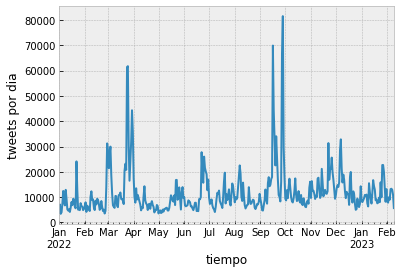

In [4]:
print("recuento total de tuits: {}\n".format(ts.sum()))
print("estadisticas de resumen \n")
print(ts.describe().drop("count"))

ts.plot()
plt.xlabel('tiempo')
plt.ylabel('tweets por dia')

## Analísis de variancia y trasformación de los datos

La *varianza* de un conjunto de datos nos indica la dispersión de los valores alrededor del promedio. Nuestro objetivo es identificar los puntos de transición entre fases estables de la serie temporal de recuentos. Para ello, necesitamos que la varianza sea más o menos estable a lo largo del tiempo.

Más allá de consideraciones técnicas, analizar las varianzas también nos proporciona información valiosa. Por un lado, los momentos en el que la varianza es particularmente alta nos indican los momentos de mayor volatilidad de la atención. Por otro lado, necesitaremos transformar los datos de una manera que estabilice la varianza para poderlos analizar. 

En la siguiente celda primero calculamos la varianza de nuestros datos sobre ventanas temporales más o menos largas (por ejemplo, de un dia) y luego la graficamos.

Nota: en este caso también hay que ajustar - si es el caso - el nombre de la columna de recuentos. 

<AxesSubplot:xlabel='start'>

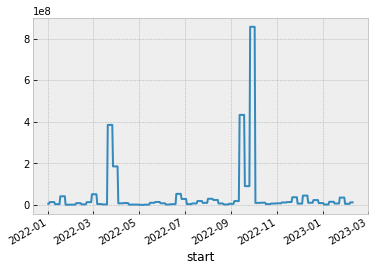

In [5]:

df["DAILY Variance"] =df.resample("W", on="start")["day_count"].transform("var")
df["DAILY Variance"].plot()

En este ejemplo, y en general cuando analizamos recuentos de tweets, observamos que la variacia depende del número de tweets. De ser este el caso, procedemos a operar una trasformación logaritmica de nuestros datos y volvemos a analizar la varianza y graficarla. 

<AxesSubplot:xlabel='start'>

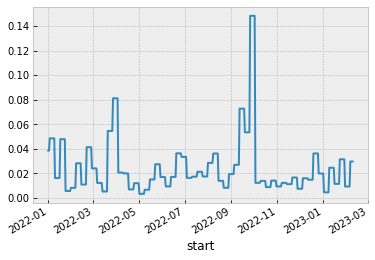

In [6]:
df['log']=np.log10(df['day_count']+1)
df["log DAILY Variance"] =df.resample("W", on="start")["log"].transform("var")


df['log DAILY Variance'].plot()

Vemos que la transformación logaritmica ha logrado estabilizar la varianza, ahora esta fluctua mucho menos.

De esta manera, también nos resulta más facil identificar los momentos de mayor volatilidad de la atención (varianza más alta).



Por comodidad en los análisis siguientes, procedemos a crear una nuevas serie temporal con los datos transformados. También la podemos graficar para una primera inspeción visual. 

<AxesSubplot:xlabel='start'>

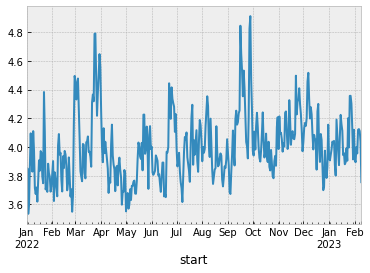

In [7]:
log_ts = df['log']
log_ts = log_ts.sort_index()
log_ts.plot()

También podemos analizar otra transformaciones de nuestros datos, en concreto, una transformaciṕn de box-cox.
Esta es una transformación que depende de un parametro addicional, por eso, primero buscamos el parametro más optimos.

In [8]:
v, l, i = boxcox(df['day_count']+1,alpha=.05)

Creamos una nueva columna del dataframe con los nuevos datos transformados y procedemos a calcular la variza y graficarla.

<AxesSubplot:xlabel='start'>

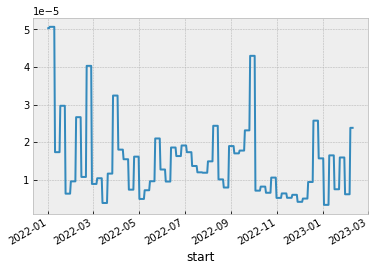

In [9]:
df['power']=v
df["power DAILY Variance"] =df.resample("W", on="start")["power"].transform("var")
df['power DAILY Variance'].plot()


La transformación de box-cox con parametro optimo nos da resultados cualitativamente similares a la transformación logaritmica. 

Como antes, procedemos a crear una nuevas serie temporal con los datos transformados y a graficarla. 


<AxesSubplot:xlabel='start'>

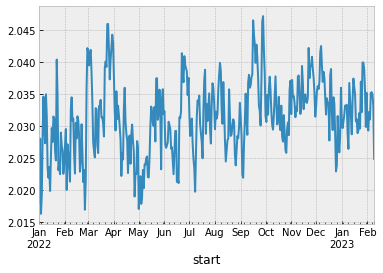

In [10]:

power_ts = df['power']
power_ts = power_ts.sort_index()
power_ts.plot()

## Diferentes granularidades y zooms

Cómo explicado en la introdución, si nos resulta útil, podemos cambiar la granularidad de los datos, subiendola.

In [11]:
ts.resample('W').sum()

start
2022-01-02 00:00:00+00:00     10848
2022-01-09 00:00:00+00:00     55017
2022-01-16 00:00:00+00:00     42526
2022-01-23 00:00:00+00:00     73917
2022-01-30 00:00:00+00:00     40601
2022-02-06 00:00:00+00:00     41844
2022-02-13 00:00:00+00:00     55838
2022-02-20 00:00:00+00:00     51884
2022-02-27 00:00:00+00:00     46367
2022-03-06 00:00:00+00:00    168166
2022-03-13 00:00:00+00:00     52219
2022-03-20 00:00:00+00:00     67887
2022-03-27 00:00:00+00:00    234125
2022-04-03 00:00:00+00:00    171301
2022-04-10 00:00:00+00:00     63003
2022-04-17 00:00:00+00:00     59632
2022-04-24 00:00:00+00:00     47637
2022-05-01 00:00:00+00:00     36840
2022-05-08 00:00:00+00:00     31629
2022-05-15 00:00:00+00:00     40375
2022-05-22 00:00:00+00:00     71894
2022-05-29 00:00:00+00:00     76404
2022-06-05 00:00:00+00:00     60106
2022-06-12 00:00:00+00:00     48309
2022-06-19 00:00:00+00:00     44623
2022-06-26 00:00:00+00:00    128439
2022-07-03 00:00:00+00:00     93946
2022-07-10 00:00:00+00

También podemos hacer zoom en alguna ventana temporal, ajustando la fecha de inicio y fin

<AxesSubplot:xlabel='start'>

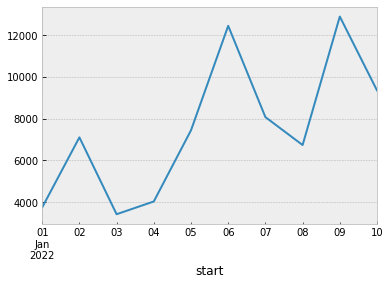

In [12]:
start="2021-12-01"
end="2022-01-10"
ts[start:end].plot(kind="line")

Lo mismo con cualquiera de nuestras series transformadas

<AxesSubplot:xlabel='start'>

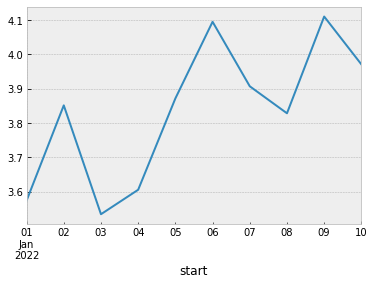

In [13]:
log_ts[start:end].plot(kind="line")

<AxesSubplot:xlabel='start'>

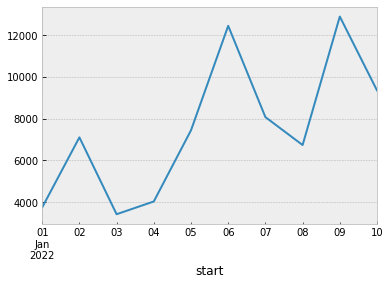

In [14]:
ts.resample('D').sum()[start:end].plot(kind="line")

<AxesSubplot:xlabel='start'>

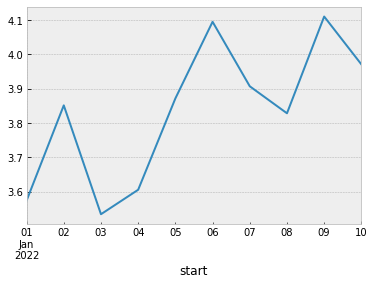

In [15]:
log_ts.resample('D').sum()[start:end].plot(kind="line")

En éste punto, ya tenemos una idea más o menos formada de la evolución de la atención y de su volatilidad. Procedemos ahora a un ánalisis más cuantitativo.

# Analísis de puntos de cambio


Preparamos los datos para ser dados como entrada de la biblioteca *ruptures*, que es la que vamos a utilizar para el análisis de puntos de camio. 

In [16]:

y = np.array(ts.tolist())
log_y=np.array(log_ts.tolist())
power_y=np.array(power_ts.tolist())

*ruptures* ofrece seis modelos diferentes para detectar puntos de ruptura. 
Cada modelo debe construirse, entrenarse (a través de la función fit()) y luego usarse para la predicción. En este tutorial utilizamos el modelo Pelt.


In [17]:
model = rpt.Pelt(model="l2").fit(log_y)
breaks = model.predict(pen=0.25)

En la variable *breaks* tenemos haora las localizaciónes de los puntos de cambios predicidos por el modelo.
Dado que *ruptures* devuelve el índice en el que ocurre el cambio estructural, recuperamos la fecha de la serie orignal ts. Recorremos el vector *breaks* hasta el penultimo valor, ya que contiene los limites de las partición generada por los puntos de cambios, y por lo tanto el último valor siempre es el indice del último punto de datos.

Finalmente procedemos a imprimir las fechas de los puntos de cambio detectados y sú numero. 

In [18]:
breaks_rpt = []
for i in breaks[:-1]:
    breaks_rpt.append(ts.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
print(breaks_rpt,len(breaks_rpt))

DatetimeIndex(['2022-02-24 00:00:00+00:00', '2022-03-06 00:00:00+00:00',
               '2022-03-21 00:00:00+00:00', '2022-03-31 00:00:00+00:00',
               '2022-04-25 00:00:00+00:00', '2022-05-15 00:00:00+00:00',
               '2022-05-30 00:00:00+00:00', '2022-06-19 00:00:00+00:00',
               '2022-06-29 00:00:00+00:00', '2022-09-12 00:00:00+00:00',
               '2022-10-02 00:00:00+00:00', '2022-11-21 00:00:00+00:00',
               '2022-12-11 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None) 13


Para obtener más o menos puntos de cambio hay que volver a ejecutar con el modelo Pelt cambiando el valor del parametro de penalización *pen* bajandolo si queremos más puntos o subiendolo si queremos menos. 

Ahora graficamos nuestra serie temporal y representamos con unas lineas rojas verticales los puntos de cambio

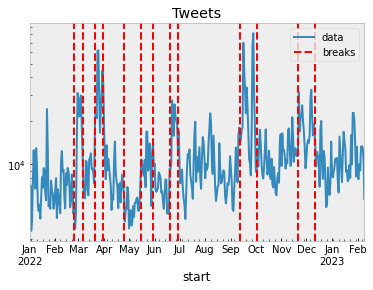

In [19]:
ts.plot(label='data')
plt.title('Tweets')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Análisis de valores atípicos

La detección de valores atípicos es una técnica que permite la identificación de puntos de datos *extraños* en un conjunto de datos. La detección de valores atípicos en un conjunto de datos implica el descubrimiento de elementos con un comportamiento anormal. Para ello usaremos la libreria *pyod*.

Preparamos los datos para ser dados como entrada de la librerua *pyod*. Conviertimos la serie temporal en un vector de *numpy* con la forma apropiada.

In [20]:
Y=np.array(log_ts.tolist()).reshape(-1,1)

Para la detección de valores atípicos usaremos un modelo basado en la proximidad. Estos modelos consideran los valores atípicos como puntos que están aislados del resto de las observaciones. La libreria *pyod* implementa varios algoritmos, en este caso vamos a usar el modelo KNN.

Construimos el modelo KNN con el compando `clf=KNN()` y lo ajustamos a nuestros datos `clf.fit(Y)`. 
Finalmente, predecimos los valores atípicos a través de la función `predict()`.

In [21]:
clf = KNN()
clf.fit(Y)

outliers = clf.predict(Y)


La variable de valores atípicos es una matriz que contiene 1 si el valor correspondiente en Y es un valor atípico, 0 en caso contrario. Por lo tanto, podemos calcular la posición de los valores atípicos a través de la función *numpy* llamada `where()`. 

Graficamos resultados. En primer lugar, calculamos Y_outliers y X_outliers

In [22]:
X=ts.index
Y_outliers = Y[np.where(outliers==1)]
X_outliers = X[np.where(outliers==1)]
Y_inliers = Y[np.where(outliers==0)]
X_inliers = X[np.where(outliers==0)]

Luego, dibujamos un diagrama de dispersión para los valores atípicos por encima del grafico de nuestros datos.

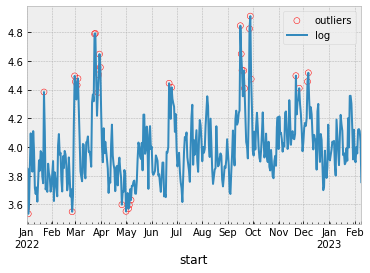

In [23]:


plt.scatter(X_outliers, Y_outliers, edgecolor='red',color='none',label='outliers')
log_ts.plot()
#plt.plot(log_ts)
plt.legend()
#plt.grid()

plt.show()

Cada algoritmo de detección de valores atípicos calcula una puntuación de anomalía para cada punto de datos. Cuanto mayor sea la puntuación de anomalía de un punto de datos, mayor será la probabilidad de que el punto de datos sea un valor atípico. Calculamos la puntuación de anomalía a través de `decision_function()`.

In [24]:
anomaly_score = clf.decision_function(Y) 

Graficamos un histograma que muestra la puntuación de anomalía y una línea vertical que muestra la puntuación de anomalía mínima utilizada por el algoritmo para detectar un valor atípico. 

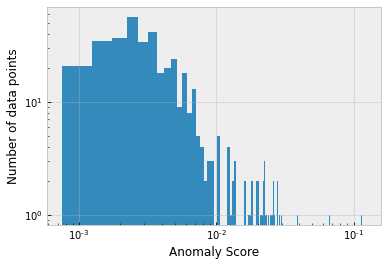

In [25]:
min_outlier_anomaly_score = np.floor(np.min(anomaly_score[np.where(outliers==1)])*10)/10
plt.hist(anomaly_score,bins=250,log=True)
plt.axvline(min_outlier_anomaly_score, c='k')
#plt.xlim(1,10000)
plt.xlabel('Anomaly Score')
plt.ylabel('Number of data points')
plt.loglog()
plt.show()



Puesto que la distribución de puntuación de anomalía suele ser de cola larga (como en este caso), hemos graficado el histograma en escala logaritmica.

Ahora, podemos definir manualmente los valores atípicos poniendo como úmbral el valor que separa la parte continua de la distribución de su parte discreta. Por ejemplo en 0.02 en los datos de ejemplo.

Nota: hay que cambiar el valot del parametro de umbral *T* en la celda siguiente, ajustandolo al que hemos establecido.

In [26]:
T=0.05
X=ts.index
Y_outliers = Y[np.where(anomaly_score >= T)]
X_outliers = X[np.where(anomaly_score >= T)]
Y_inliers = Y[np.where(anomaly_score < T)]
X_inliers = X[np.where(anomaly_score < T)]

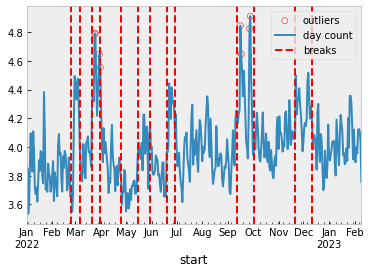

In [27]:
plt.scatter(X_outliers, Y_outliers, edgecolor='red',color='none',label='outliers')
log_ts.plot(label='day count')
print_legend=True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
        
plt.legend()
plt.grid()
plt.show()

Podemos proceder a imprimir las fechas de los valores atípicos de detectados.



In [28]:
X[np.where(anomaly_score >= T)]

DatetimeIndex(['2022-03-24 00:00:00+00:00', '2022-03-25 00:00:00+00:00',
               '2022-03-30 00:00:00+00:00', '2022-03-31 00:00:00+00:00',
               '2022-09-16 00:00:00+00:00', '2022-09-17 00:00:00+00:00',
               '2022-09-27 00:00:00+00:00', '2022-09-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='start', freq=None)

# Análisis Comparativo 

En este último apartado vamos a comparar la evolución de dos series temporales distintas. Dos tipos de análisis son de interes: 

- la comparación con la evolución de un *termino de referencia*
- la comparación con la evolución de un tema competidor

La comparación con la evolución de un termino de referencia, es decir, una palabra de uso común, es útil para poder confirmar que los puntos de cambios y valores anómalos encontrados no son debidos a efectos generales (cambios en el número de usuarios, por ejemplo) sino a dínamicas propias del tema analizado. 

## Carga y preparación de datos

En primer lugar, cargamos el nuevo conjunto de datos en otro *dataframe* . 


In [29]:
df2 = pd.read_csv('../datos/crisis_clima-sme2022.csv')
df2.tail()

,start,end,hour_count
9767,2022-01-04T23:00:00.000Z,2022-01-05T00:00:00.000Z,64
9768,2022-01-05T00:00:00.000Z,2022-01-05T01:00:00.000Z,62
9769,2022-01-05T01:00:00.000Z,2022-01-05T02:00:00.000Z,39
9770,2022-01-05T02:00:00.000Z,2022-01-05T03:00:00.000Z,56
9771,2022-01-05T03:00:00.000Z,2022-01-05T04:00:00.000Z,43


Ahora convertimos el *dataframe* en una *serie temporal* de la libreria *pandas*.
Nota: hay que ajustar el nombre de la columna de recuentos a la granularidad escogida. La granularidad de las dos series temporales tiene que ser la miasma.

In [30]:
df2['start'] = pd.to_datetime(df2['start'])
df2.set_index(df2['start'], inplace = True)

ts2 = df2['hour_count']
ts2 = ts2.sort_index()

<AxesSubplot:xlabel='start'>

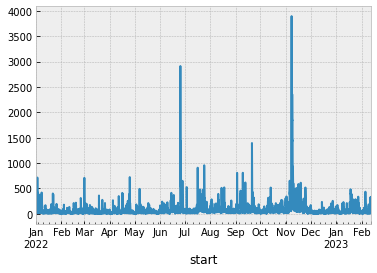

In [31]:
ts2.plot()

Creamos una nueva variable que es el ratio de los dos recuentos. Hacemos un resample para ajustar la granularidad de una serie a otra si es el caso.

In [32]:
rt=ts2.resample('D').sum()/ts

<AxesSubplot:xlabel='start'>

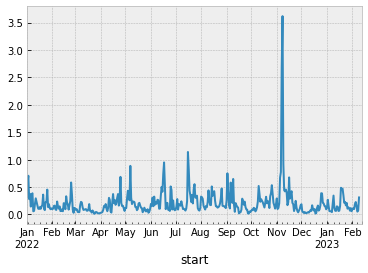

In [33]:
rt.plot()

In [34]:
z = np.array(np.log(rt.tolist()))

Útilizamos el modelo *Pelt* de la libreria *rupture* para encontrar los puntos de cabio.
Como antes, podemos ajustar el valor del parametro *pen* para obtener más o menos puntos de cambio.

In [35]:
model = rpt.Pelt(model="l2")
model.fit(z)
breaks = model.predict(pen=6)

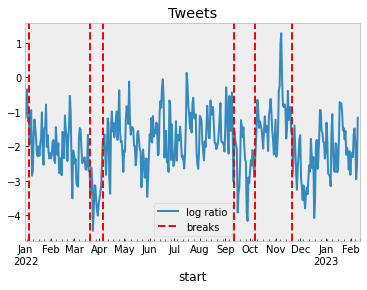

In [37]:
breaks_rpt = []
for i in breaks[:-1]:
    breaks_rpt.append(rt.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

#plt.plot(ts, label='data')
np.log(rt).plot(label='log ratio')
plt.title('Tweets')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid()
plt.legend()
plt.show()